# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Evaluate](#Evaluate)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

Feature engineering could continue ad infinitum. Any classifier that implements .predict_proba can generate per-class features that could be useful (calibration can enable predict_proba for models that don't natively implement). These probabilities are all new features. And then two LDA components can be extracted from each of these trios. What's more, you could select any intermediate stage of feature extraction and generate more predicted probabilities or components. And don't forget we have the original FRILL features to tinker with too!

This approach will be limited by how good the FRILL embeddings are without returning to the raw signal. As such, it is worth it to produce such features using the most performant models, as we did with SVM.

This notebook examines the efficacy of bespoke FRILL-based features with ExtraTreesClassifier. I chose it because it is fast and has demonstrated some skill with the new features on a fold. I can settle on the harness with this model and then subsequent notebooks will reexamine the top contenders: GaussianNB, LogisticRegression, Ridge. SVC was a top model too, but I suspect its comparative advantages are diminished in the presence of the one-class SVM features; it's also pretty slow.

Henceforth, we will be considering one model at a time per notebook. We will save the cv_results_ so they can be analyzed post hoc as well. Predictions were variously saved, but we can later retrain using the parameters recorded in cv_results_ if we want to examine them.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect

# from joblib import Memory
# from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    make_scorer,
)

# # other imblearn
# from imblearn.combine import SMOTEENN, SMOTETomek
# from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE
# from imblearn.under_sampling import (
#     AllKNN,
#     EditedNearestNeighbours,
#     OneSidedSelection,
#     TomekLinks,
# )
# from imblearn.pipeline import Pipeline

# other sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# param distributions
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.18 s


In [4]:
# Location of cross validation data
FEATURES_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 95.8 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
# combined_resamplers = lambda: [
#     SMOTEENN(
#         random_state=SEED,
#         smote=SMOTE(random_state=SEED, n_jobs=-1),
#         enn=EditedNearestNeighbours(n_jobs=-1),
#         n_jobs=-1,
#     ),
#     SMOTETomek(
#         random_state=SEED,
#         smote=SMOTE(random_state=SEED, n_jobs=-1),
#         tomek=TomekLinks(n_jobs=-1),
#         n_jobs=-1,
#     ),
#     "passthrough",
# ]

_ = gc_collect()

time: 95.5 ms


In [6]:
FOLDS = (0, 1, 2, 3, 4)

METRICS = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_weighted": "f1_weighted",
    "geometric_mean": make_scorer(geometric_mean_score),
    "roc_auc_ovo": "roc_auc_ovo",
    "roc_auc_ovr": "roc_auc_ovr",
    "roc_auc_ovo_weighted": "roc_auc_ovo_weighted",
    "roc_auc_ovr_weighted": "roc_auc_ovr_weighted",
}

SCORERS = {
    "accuracy": accuracy_score,
    "adjusted_balanced_accuracy": lambda y_true, y_pred: balanced_accuracy_score(
        y_true, y_pred, adjusted=True
    ),
    "f1_weighted": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
    "geometric_mean": geometric_mean_score,
    "roc_auc_ovo": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, multi_class="ovo"
    ),
    "roc_auc_ovr": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, multi_class="ovr"
    ),
    "roc_auc_ovo_weighted": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, average="weighted", multi_class="ovo"
    ),
    "roc_auc_ovr_weighted": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, average="weighted", multi_class="ovr"
    ),
}


def make_ExtraTreesClassifier(
    new_params: Dict[str, Any] = dict()
) -> ExtraTreesClassifier:
    """Returns a new instance of the base ExtraTreesClassifier"""
    return ExtraTreesClassifier(n_jobs=-1, random_state=SEED, verbose=1, **new_params)


common_params = {
    "scale": [
        StandardScaler(),
        PowerTransformer(),
        QuantileTransformer(output_distribution="normal"),
        QuantileTransformer(output_distribution="uniform"),
    ],
    "clf__n_estimators": list(range(80, 201)),
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 5, 10, 15, 20, 25],
    "clf__min_samples_leaf": list(range(1, 11)),
    "clf__min_samples_split": list(range(2, 6)),
    "clf__max_leaf_nodes": [None, 10, 20, 30, 40, 50],
    "clf__min_impurity_decrease": uniform(0.0, 0.25),
    "clf__bootstrap": [False, True],
    "clf__class_weight": [None, "balanced", "balanced_subsample"],
    "clf__ccp_alpha": uniform(0.0, 0.05),
    "clf__max_samples": uniform(0.75, 0.25),
    # "resample": combined_resamplers(),
}

# too slow!
# rfecv_grid = lambda before_or_after: {
#     f"select_{before_or_after}": [
#         RFECV(
#             estimator=make_ExtraTreesClassifier(),
#             min_features_to_select=3,
#             verbose=1,
#             n_jobs=-1,
#         )
#     ],
#     f"select_{before_or_after}__scoring": list(METRICS.values()),
# }

selectfrommodel_grid = lambda before_or_after: {
    f"select_{before_or_after}": [
        SelectFromModel(
            estimator=make_ExtraTreesClassifier(),
            max_features=500,
        )
    ],
    f"select_{before_or_after}__threshold": [f"0.{i}*mean" for i in range(1, 10)]
    + ["1.1*mean", "mean"],
}

selectkbest_grid = lambda before_or_after: {
    f"select_{before_or_after}": [SelectKBest()],
    f"select_{before_or_after}__k": list(range(5, 21)),
}

make_pipeline = lambda: Pipeline(
    steps=[
        ("scale", "passthrough"),
        ("select_before", "passthrough"),
        # ("resample", "passthrough"),
        # ("select_after", "passthrough"),
        (
            "clf",
            ExtraTreesClassifier(n_jobs=-1, random_state=SEED, verbose=1),
        ),
    ],
)

_ = gc_collect()

time: 109 ms


# Evaluate

In [7]:
hypersearched_params = {0: [], 1: [], 2: [], 3: [], 4: []}
already_completed: List[int] = []
for fold_num in tqdm(FOLDS):
    if fold_num in already_completed:
        continue
    fold_begin = time()

    read_feather = lambda filename: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather"
    )

    # fit hypersearch
    print("fitting hypersearch...")
    hypersearch = RandomizedSearchCV(
        estimator=make_pipeline(),
        param_distributions=[
            {
                **common_params,
                **selectfrommodel_grid("before"),
            },
            {
                **common_params,
                **selectkbest_grid("before"),
            },
        ],
        n_iter=500,
        scoring=METRICS,
        n_jobs=-1,
        refit=False,
        verbose=1,
        random_state=SEED,
        error_score="raise",
    ).fit(
        X_train := read_feather("X_train_nonFRILL"),
        y_train := read_feather("y_train_untransformed").iloc[:, 0],
    )

    # save CV results
    df = pd.DataFrame(hypersearch.cv_results_)
    convert_to_string = [
        "param_scale",
        "param_select_before",
        "params",
    ]  # convert unserializable object columns to str
    df.loc[:, convert_to_string] = df.loc[:, convert_to_string].astype(str)
    df["fold_num"] = fold_num
    df.to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/ExtraTrees_hypersearch.feather"
    )
    del convert_to_string
    _ = gc_collect()

    df = pd.DataFrame(hypersearch.cv_results_)  # reset
    del hypersearch
    _ = gc_collect()
    best_scores = {  # record best scores for selected hyperparameter lookup
        metric: df.loc[:, [f"mean_test_{metric}"]]
        .query(
            # select rows where mean_test_score == (mean_test_score of rank #1)
            f"mean_test_{metric} == {df.query(f'rank_test_{metric} == 1')[f'mean_test_{metric}'].iat[0]}"
        )
        .iat[0, 0]  # then select the top score
        for metric in METRICS.keys()
    }

    # read test data
    X_test = read_feather("X_test_nonFRILL")
    y_test = read_feather("y_test_untransformed").iloc[:, 0]
    del read_feather
    _ = gc_collect()

    # evaluate hyperparameters
    print("evaluating hyperparameters...")
    results = {
        "fold_num": [],
        "target_score": [],
        "steps": [],
        "fit_time": [],
        "predict_time": [],
        **{key: [] for key in SCORERS.keys()},
    }
    for metric in best_scores:  # multiple refits
        best_ones = df.query(f"mean_test_{metric} == {best_scores[metric]}")
        if len(best_ones) > 1:  # select rows with best scores
            # break ties
            best_ones = best_ones.sort_values(
                by=[
                    "mean_fit_time",
                    "mean_score_time",
                    "std_fit_time",
                    "std_score_time",
                ],
                ascending=True,
            )

        # obtain best hyperparameters for the metric under consideration
        params: Dict[str, Any] = deepcopy(best_ones.params.iat[0])
        del best_ones
        _ = gc_collect()

        # record scores
        results["target_score"].append(metric)
        if (param_string := str(params)) in (
            str_hypersearched_params := [str(_) for _ in hypersearched_params[fold_num]]
        ):
            print("hyperparameters are redundant")
            # skip redundant fits of individual configurations
            # relevant where one configuration outperforms many others and achieves rank #1 for many scores
            for key in results.keys():
                if key == "target_score":
                    continue
                results[key].append(
                    deepcopy(results[key][str_hypersearched_params.index(param_string)])
                )
        else:
            print("new hyperparameters found")
            # record new hyperparameter set
            assert "scale" in params.keys() and "select_before" in params.keys()
            hypersearched_params[fold_num].append(deepcopy(params))
            _ = gc_collect()
            # set pipeline parameters accordingly
            pipe = make_pipeline()
            pipe.set_params(scale=params["scale"])
            del params["scale"]
            if "select_before__k" in params.keys():
                pipe.set_params(select_before=SelectKBest(k=params["select_before__k"]))
                del params["select_before__k"]
            elif "select_before__threshold" in params.keys():
                pipe.set_params(
                    select_before=SelectFromModel(
                        threshold=params["select_before__threshold"]
                    )
                )
                del params["select_before__threshold"]
            del params["select_before"]
            pipe.set_params(
                clf=make_ExtraTreesClassifier(
                    {param.split("__")[-1]: params[param] for param in params}
                )
            )
            del params
            _ = gc_collect()

            # fit
            print("fitting...")
            begin = time()
            pipe.fit(X_train, y_train)
            end = time()
            results["fit_time"].append(end - begin)

            # predict
            print("predicting...")
            begin = time()
            y_pred = pipe.predict(X_test)
            end = time()
            results["predict_time"].append(end - begin)
            proba_predict = pipe.predict_proba(X_test)

            # save predictions
            pred_df = pd.DataFrame(proba_predict)
            pred_df.columns = pred_df.columns.astype(str)
            pred_df.to_feather(
                f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/best_{metric}_predictions_ExtraTrees.feather"
            )
            del pred_df
            _ = gc_collect()

            results["fold_num"].append(fold_num)
            results["steps"].append(str(pipe.steps))
            print("evaluating...")
            # score
            for scorer in SCORERS:
                try:
                    results[scorer].append(score := SCORERS[scorer](y_test, y_pred))
                except np.AxisError:  # roc_auc needs probabilities
                    results[scorer].append(
                        score := SCORERS[scorer](y_test, proba_predict)
                    )
                print(f"{scorer}: {score:.3f}")
            del y_pred
            del proba_predict
            del score
            _ = gc_collect()

    # save fold results
    pd.DataFrame(results).to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/ExtraTrees_results.feather"
    )

    del X_train
    del X_test
    del y_train
    del y_test
    del results
    _ = gc_collect()

    print(f"fold {fold_num} completed in {time() - fold_begin:.2f} seconds")
    del fold_begin
    _ = gc_collect()

  0%|          | 0/5 [00:00<?, ?it/s]

fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


Pipeline(steps=[('scale', StandardScaler()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.04797808973893954,
                                      class_weight='balanced', max_depth=10,
                                      max_leaf_nodes=40,
                                      max_samples=0.832172251549802,
                                      min_impurity_decrease=0.06501836170991304,
                                      min_samples_leaf=7, min_samples_split=4,
                                      n_estimators=175, n_jobs=-1,
                                      random_state=2021, verbose=1))])

fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.5s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.04797808973893954,
                                      class_weight='balanced', max_depth=10,
                                      max_leaf_nodes=40,
                                      max_samples=0.832172251549802,
                                      min_impurity_decrease=0.06501836170991304,
                                      min_samples_leaf=7, min_samples_split=4,
                                      n_estimators=175, n_jobs=-1,
                                      random_state=2021, verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished


predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished


evaluating...
accuracy: 0.663
adjusted_balanced_accuracy: 0.333
f1_weighted: 0.639
geometric_mean: 0.500
roc_auc_ovo: 0.764
roc_auc_ovr: 0.757
roc_auc_ovo_weighted: 0.756
roc_auc_ovr_weighted: 0.743
new hyperparameters found


Pipeline(steps=[('scale', PowerTransformer()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.015400669509352805,
                                      class_weight='balanced_subsample',
                                      criterion='entropy', max_depth=15,
                                      max_leaf_nodes=20,
                                      max_samples=0.8133622201504886,
                                      min_impurity_decrease=0.027500767561100647,
                                      min_samples_leaf=6, min_samples_split=3,
                                      n_estimators=195, n_jobs=-1,
                                      random_state=2021, verbose=1))])

fitting...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [172] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    0.6s finished


Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.015400669509352805,
                                      class_weight='balanced_subsample',
                                      criterion='entropy', max_depth=15,
                                      max_leaf_nodes=20,
                                      max_samples=0.8133622201504886,
                                      min_impurity_decrease=0.027500767561100647,
                                      min_samples_leaf=6, min_samples_split=3,
                                      n_estimators=195, n_jobs=-1,
                                      random_state=2021, verbose=1))])

predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.0s finished


evaluating...
accuracy: 0.653
adjusted_balanced_accuracy: 0.381
f1_weighted: 0.644
geometric_mean: 0.557
roc_auc_ovo: 0.779
roc_auc_ovr: 0.767
roc_auc_ovo_weighted: 0.767
roc_auc_ovr_weighted: 0.749
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


Pipeline(steps=[('scale', PowerTransformer()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.012036346455314751,
                                      class_weight='balanced',
                                      max_leaf_nodes=50,
                                      max_samples=0.9747622182167597,
                                      min_impurity_decrease=0.004725260889063387,
                                      min_samples_leaf=6, n_estimators=188,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [172] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 188 out of 188 | elapsed:    0.6s finished


Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.012036346455314751,
                                      class_weight='balanced',
                                      max_leaf_nodes=50,
                                      max_samples=0.9747622182167597,
                                      min_impurity_decrease=0.004725260889063387,
                                      min_samples_leaf=6, n_estimators=188,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 188 out of 188 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 188 out of 188 | elapsed:    0.0s finished


evaluating...
accuracy: 0.645
adjusted_balanced_accuracy: 0.378
f1_weighted: 0.640
geometric_mean: 0.562
roc_auc_ovo: 0.770
roc_auc_ovr: 0.760
roc_auc_ovo_weighted: 0.759
roc_auc_ovr_weighted: 0.744
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 0 completed in 19753.49 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


Pipeline(steps=[('scale', StandardScaler()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.04797808973893954,
                                      class_weight='balanced', max_depth=10,
                                      max_leaf_nodes=40,
                                      max_samples=0.832172251549802,
                                      min_impurity_decrease=0.06501836170991304,
                                      min_samples_leaf=7, min_samples_split=4,
                                      n_estimators=175, n_jobs=-1,
                                      random_state=2021, verbose=1))])

fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.6s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.04797808973893954,
                                      class_weight='balanced', max_depth=10,
                                      max_leaf_nodes=40,
                                      max_samples=0.832172251549802,
                                      min_impurity_decrease=0.06501836170991304,
                                      min_samples_leaf=7, min_samples_split=4,
                                      n_estimators=175, n_jobs=-1,
                                      random_state=2021, verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


predicting...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished


evaluating...
accuracy: 0.640
adjusted_balanced_accuracy: 0.350
f1_weighted: 0.634
geometric_mean: 0.546
roc_auc_ovo: 0.779
roc_auc_ovr: 0.770
roc_auc_ovo_weighted: 0.768
roc_auc_ovr_weighted: 0.753
new hyperparameters found


Pipeline(steps=[('scale', PowerTransformer()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.0386207591845851,
                                      class_weight='balanced',
                                      criterion='entropy', max_depth=25,
                                      max_leaf_nodes=40,
                                      max_samples=0.8728603436522121,
                                      min_impurity_decrease=0.03392211771932527,
                                      min_samples_split=3, n_estimators=88,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [172] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:    0.3s finished


Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.0386207591845851,
                                      class_weight='balanced',
                                      criterion='entropy', max_depth=25,
                                      max_leaf_nodes=40,
                                      max_samples=0.8728603436522121,
                                      min_impurity_decrease=0.03392211771932527,
                                      min_samples_split=3, n_estimators=88,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  88 out of  88 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  88 out of  88 | elapsed:    0.0s finished


evaluating...
accuracy: 0.635
adjusted_balanced_accuracy: 0.371
f1_weighted: 0.634
geometric_mean: 0.569
roc_auc_ovo: 0.799
roc_auc_ovr: 0.785
roc_auc_ovo_weighted: 0.783
roc_auc_ovr_weighted: 0.762
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


Pipeline(steps=[('scale', PowerTransformer()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.004054689740604761,
                                      class_weight='balanced_subsample',
                                      max_depth=10, max_leaf_nodes=20,
                                      max_samples=0.920571102661142,
                                      min_impurity_decrease=0.000669631864766318,
                                      min_samples_leaf=8, n_estimators=161,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [172] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    0.5s finished


Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.004054689740604761,
                                      class_weight='balanced_subsample',
                                      max_depth=10, max_leaf_nodes=20,
                                      max_samples=0.920571102661142,
                                      min_impurity_decrease=0.000669631864766318,
                                      min_samples_leaf=8, n_estimators=161,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished


evaluating...
accuracy: 0.631
adjusted_balanced_accuracy: 0.370
f1_weighted: 0.631
geometric_mean: 0.567
roc_auc_ovo: 0.790
roc_auc_ovr: 0.778
roc_auc_ovo_weighted: 0.776
roc_auc_ovr_weighted: 0.758
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 1 completed in 20072.91 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


Pipeline(steps=[('scale', StandardScaler()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.035362295991831265,
                                      class_weight='balanced', max_depth=5,
                                      max_leaf_nodes=30,
                                      max_samples=0.8629774593902722,
                                      min_impurity_decrease=0.14456549274058328,
                                      min_samples_leaf=8, n_estimators=112,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.5s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.035362295991831265,
                                      class_weight='balanced', max_depth=5,
                                      max_leaf_nodes=30,
                                      max_samples=0.8629774593902722,
                                      min_impurity_decrease=0.14456549274058328,
                                      min_samples_leaf=8, n_estimators=112,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:    0.0s finished


predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:    0.0s finished


evaluating...
accuracy: 0.583
adjusted_balanced_accuracy: 0.301
f1_weighted: 0.584
geometric_mean: 0.520
roc_auc_ovo: 0.732
roc_auc_ovr: 0.733
roc_auc_ovo_weighted: 0.731
roc_auc_ovr_weighted: 0.731
new hyperparameters found


Pipeline(steps=[('scale', PowerTransformer()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.011358933991956295,
                                      class_weight='balanced', max_depth=15,
                                      max_leaf_nodes=30,
                                      max_samples=0.8758506243594858,
                                      min_impurity_decrease=0.20266870453851799,
                                      min_samples_leaf=6, min_samples_split=5,
                                      n_estimators=161, n_jobs=-1,
                                      random_state=2021, verbose=1))])

fitting...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    0.6s finished


Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.011358933991956295,
                                      class_weight='balanced', max_depth=15,
                                      max_leaf_nodes=30,
                                      max_samples=0.8758506243594858,
                                      min_impurity_decrease=0.20266870453851799,
                                      min_samples_leaf=6, min_samples_split=5,
                                      n_estimators=161, n_jobs=-1,
                                      random_state=2021, verbose=1))])

predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished


evaluating...
accuracy: 0.565
adjusted_balanced_accuracy: 0.343
f1_weighted: 0.574
geometric_mean: 0.557
roc_auc_ovo: 0.739
roc_auc_ovr: 0.734
roc_auc_ovo_weighted: 0.733
roc_auc_ovr_weighted: 0.733
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


Pipeline(steps=[('scale', StandardScaler()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.006848380760765216,
                                      class_weight='balanced', max_depth=15,
                                      max_leaf_nodes=40,
                                      max_samples=0.9392268887346455,
                                      min_impurity_decrease=0.028268754667265472,
                                      min_samples_leaf=7, min_samples_split=4,
                                      n_estimators=161, n_jobs=-1,
                                      random_state=2021, verbose=1))])

fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    0.4s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=6)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.006848380760765216,
                                      class_weight='balanced', max_depth=15,
                                      max_leaf_nodes=40,
                                      max_samples=0.9392268887346455,
                                      min_impurity_decrease=0.028268754667265472,
                                      min_samples_leaf=7, min_samples_split=4,
                                      n_estimators=161, n_jobs=-1,
                                      random_state=2021, verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


predicting...


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished


evaluating...
accuracy: 0.596
adjusted_balanced_accuracy: 0.321
f1_weighted: 0.591
geometric_mean: 0.519
roc_auc_ovo: 0.750
roc_auc_ovr: 0.748
roc_auc_ovo_weighted: 0.746
roc_auc_ovr_weighted: 0.746
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 2 completed in 17541.72 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


Pipeline(steps=[('scale', StandardScaler()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.035362295991831265,
                                      class_weight='balanced', max_depth=5,
                                      max_leaf_nodes=30,
                                      max_samples=0.8629774593902722,
                                      min_impurity_decrease=0.14456549274058328,
                                      min_samples_leaf=8, n_estimators=112,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.4s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.035362295991831265,
                                      class_weight='balanced', max_depth=5,
                                      max_leaf_nodes=30,
                                      max_samples=0.8629774593902722,
                                      min_impurity_decrease=0.14456549274058328,
                                      min_samples_leaf=8, n_estimators=112,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:    0.0s finished


predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:    0.0s finished


evaluating...
accuracy: 0.610
adjusted_balanced_accuracy: 0.297
f1_weighted: 0.595
geometric_mean: 0.486
roc_auc_ovo: 0.729
roc_auc_ovr: 0.727
roc_auc_ovo_weighted: 0.725
roc_auc_ovr_weighted: 0.720
new hyperparameters found


Pipeline(steps=[('scale', PowerTransformer()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.004054689740604761,
                                      class_weight='balanced_subsample',
                                      max_depth=10, max_leaf_nodes=20,
                                      max_samples=0.920571102661142,
                                      min_impurity_decrease=0.000669631864766318,
                                      min_samples_leaf=8, n_estimators=161,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [130 172] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.004054689740604761,
                                      class_weight='balanced_subsample',
                                      max_depth=10, max_leaf_nodes=20,
                                      max_samples=0.920571102661142,
                                      min_impurity_decrease=0.000669631864766318,
                                      min_samples_leaf=8, n_estimators=161,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished


evaluating...
accuracy: 0.605
adjusted_balanced_accuracy: 0.313
f1_weighted: 0.595
geometric_mean: 0.506
roc_auc_ovo: 0.747
roc_auc_ovr: 0.741
roc_auc_ovo_weighted: 0.739
roc_auc_ovr_weighted: 0.730
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 3 completed in 15219.42 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


Pipeline(steps=[('scale', StandardScaler()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.035362295991831265,
                                      class_weight='balanced', max_depth=5,
                                      max_leaf_nodes=30,
                                      max_samples=0.8629774593902722,
                                      min_impurity_decrease=0.14456549274058328,
                                      min_samples_leaf=8, n_estimators=112,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.4s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(bootstrap=True,
                                      ccp_alpha=0.035362295991831265,
                                      class_weight='balanced', max_depth=5,
                                      max_leaf_nodes=30,
                                      max_samples=0.8629774593902722,
                                      min_impurity_decrease=0.14456549274058328,
                                      min_samples_leaf=8, n_estimators=112,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


predicting...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:    0.0s finished


evaluating...
accuracy: 0.585
adjusted_balanced_accuracy: 0.322
f1_weighted: 0.580
geometric_mean: 0.529
roc_auc_ovo: 0.747
roc_auc_ovr: 0.750
roc_auc_ovo_weighted: 0.748
roc_auc_ovr_weighted: 0.749
new hyperparameters found


Pipeline(steps=[('scale', StandardScaler()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.04704742440228131,
                                      class_weight='balanced', max_depth=5,
                                      max_samples=0.7722593272493494,
                                      min_impurity_decrease=0.04531285682137759,
                                      min_samples_leaf=9, min_samples_split=4,
                                      n_estimators=89, n_jobs=-1,
                                      random_state=2021, verbose=1))])

fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    0.2s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.04704742440228131,
                                      class_weight='balanced', max_depth=5,
                                      max_samples=0.7722593272493494,
                                      min_impurity_decrease=0.04531285682137759,
                                      min_samples_leaf=9, min_samples_split=4,
                                      n_estimators=89, n_jobs=-1,
                                      random_state=2021, verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


evaluating...
accuracy: 0.584
adjusted_balanced_accuracy: 0.337
f1_weighted: 0.582
geometric_mean: 0.546
roc_auc_ovo: 0.745
roc_auc_ovr: 0.748
roc_auc_ovo_weighted: 0.746
roc_auc_ovr_weighted: 0.748
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


Pipeline(steps=[('scale', PowerTransformer()), ('select_before', 'passthrough'),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(n_jobs=-1, random_state=2021,
                                      verbose=1))])

Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.004054689740604761,
                                      class_weight='balanced_subsample',
                                      max_depth=10, max_leaf_nodes=20,
                                      max_samples=0.920571102661142,
                                      min_impurity_decrease=0.000669631864766318,
                                      min_samples_leaf=8, n_estimators=161,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

fitting...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [130] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    0.5s finished


Pipeline(steps=[('scale', PowerTransformer()),
                ('select_before', SelectKBest(k=5)),
                ('clf',
                 ExtraTreesClassifier(ccp_alpha=0.004054689740604761,
                                      class_weight='balanced_subsample',
                                      max_depth=10, max_leaf_nodes=20,
                                      max_samples=0.920571102661142,
                                      min_impurity_decrease=0.000669631864766318,
                                      min_samples_leaf=8, n_estimators=161,
                                      n_jobs=-1, random_state=2021,
                                      verbose=1))])

predicting...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished


evaluating...
accuracy: 0.582
adjusted_balanced_accuracy: 0.341
f1_weighted: 0.581
geometric_mean: 0.548
roc_auc_ovo: 0.749
roc_auc_ovr: 0.751
roc_auc_ovo_weighted: 0.749
roc_auc_ovr_weighted: 0.750
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 4 completed in 17790.96 seconds
time: 1d 1h 6min 19s


In [8]:
hypersearched_params_ = deepcopy(hypersearched_params)

[len(_) for _ in hypersearched_params_.values()]
maxlen = max(len(_) for _ in hypersearched_params_.values())
for key in hypersearched_params_.keys():
    hypersearched_params_[key] = np.pad(
        hypersearched_params_[key],
        (0, maxlen - len(hypersearched_params_[key])),
        mode="empty",
    )
[len(_) for _ in hypersearched_params_.values()]

[3, 3, 3, 2, 3]

[3, 3, 3, 3, 3]

time: 11 ms


In [9]:
# checkpoint recorded hyperparameters
params_checkpoint = pd.DataFrame(hypersearched_params_).astype(str)
params_checkpoint.columns = params_checkpoint.columns.astype(str)
params_checkpoint.to_feather(
    f"{DATA_OUT_FOLDER}/hypersearched_params_checkpoint_ExtraTrees.feather"
)
del params_checkpoint
_ = gc_collect()

time: 150 ms


The same hyperparameter configurations are tried on each fold (outer) due to the predetermined seed.

In [10]:
# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

time: 1.02 ms


In [11]:
results_df = pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/ExtraTrees_results.feather"
        )
        for fold_num in (0, 1, 2, 3, 4)
    ]
)
results_df.head(10)

,fold_num,target_score,steps,fit_time,predict_time,accuracy,adjusted_balanced_accuracy,f1_weighted,geometric_mean,roc_auc_ovo,roc_auc_ovr,roc_auc_ovo_weighted,roc_auc_ovr_weighted
0,0,accuracy,"[('scale', StandardScaler()), ('select_before', SelectKBest(k=5)), ('clf', ExtraTreesClassifier(ccp_alpha=0.04797808973893954, class_weight='balanced',\n max_depth=10, max_leaf_nodes=40,\n max_samples=0.832172251549802,\n min_impurity_decrease=0.06501836170991304,\n min_samples_leaf=7, min_samples_split=4, n_estimators=175,\n n_jobs=-1, random_state=2021, verbose=1))]",2.439576,0.158951,0.662665,0.333455,0.639493,0.500117,0.764255,0.757352,0.756060,0.742568
1,0,balanced_accuracy,"[('scale', PowerTransformer()), ('select_before', SelectKBest(k=6)), ('clf', ExtraTreesClassifier(ccp_alpha=0.015400669509352805,\n class_weight='balanced_subsample', criterion='entropy',\n max_depth=15, max_leaf_nodes=20,\n max_samples=0.8133622201504886,\n min_impurity_decrease=0.027500767561100647,\n min_samples_leaf=6, min_samples_split=3, n_estimators=195,\n n_jobs=-1, random_state=2021, verbose=1))]",51.732475,0.557880,0.652735,0.381087,0.643777,0.556932,0.779185,0.767351,0.766755,0.749173
2,0,f1_weighted,"[('scale', StandardScaler()), ('select_before', SelectKBest(k=5)), ('clf', ExtraTreesClassifier(ccp_alpha=0.04797808973893954, class_weight='balanced',\n max_depth=10, max_leaf_nodes=40,\n max_samples=0.832172251549802,\n min_impurity_decrease=0.06501836170991304,\n min_samples_leaf=7, min_samples_split=4, n_estimators=175,\n n_jobs=-1, random_state=2021, verbose=1))]",2.439576,0.158951,0.662665,0.333455,0.639493,0.500117,0.764255,0.757352,0.756060,0.742568
3,0,geometric_mean,"[('scale', PowerTransformer()), ('select_before', SelectKBest(k=6)), ('clf', ExtraTreesClassifier(ccp_alpha=0.015400669509352805,\n class_weight='balanced_subsample', criterion='entropy',\n max_depth=15, max_leaf_nodes=20,\n max_samples=0.8133622201504886,\n min_impurity_decrease=0.027500767561100647,\n min_samples_leaf=6, min_samples_split=3, n_estimators=195,\n n_jobs=-1, random_state=2021, verbose=1))]",51.732475,0.557880,0.652735,0.381087,0.643777,0.556932,0.779185,0.767351,0.766755,0.749173
4,0,roc_auc_ovo,"[('scale', PowerTransformer()), ('select_before', SelectKBest(k=5)), ('clf', ExtraTreesClassifier(ccp_alpha=0.012036346455314751, class_weight='balanced',\n max_leaf_nodes=50, max_samples=0.9747622182167597,\n min_impurity_decrease=0.004725260889063387,\n min_samples_leaf=6, n_estimators=188, n_jobs=-1,\n random_state=2021, verbose=1))]",48.482356,0.549903,0.645324,0.378011,0.639972,0.561704,0.769689,0.760312,0.759459,0.744214
5,0,roc_auc_ovr,"[('scale', StandardScaler()), ('select_before', SelectKBest(k=5)), ('clf', ExtraTreesClassifier(ccp_alpha=0.04797808973893954, class_weight='balanced',\n max_depth=10, max_leaf_nodes=40,\n max_samples=0.832172251549802,\n min_impurity_decrease=0.06501836170991304,\n min_samples_leaf=7, min_samples_split=4, n_estimators=175,\n n_jobs=-1, random_state=2021, verbose=1))]",2.439576,0.158951,0.662665,0.333455,0.639493,0.500117,0.764255,0.757352,0.756060,0.742568
6,0,roc_auc_ovo_weighted,"[('scale', StandardScaler()), ('select_before', SelectKBest(k=5)), ('clf', ExtraTreesClassifier(ccp_alpha=0.04797808973893954, class_weight='balanced',\n max_depth=10, max_leaf_nodes=40,\n max_samples=0.832172251549802,\n min_impurity_decrease=0.06501836170991304,\n min_samples_leaf=7, min_samples_split=4, n_estimators=175,\n n_jobs=-1, random_state=2021, verbose=1))]",2.439576,0.158951,0.662665,0.333455,0.639493,0.500117,0.764255,0.757352,0.756060,0.742568
7,0,roc_auc_ovr_weighted,"[('scale', StandardScaler()), ('select_before', SelectKBest(k=5)), ('clf', ExtraTreesClassifier(ccp_alpha=0.04797808973893954, class_weight='balanced',\n max_depth=10, max_leaf_nodes=40,\n max_samples=0.832172251549802,\n min_impurity_decrease=0.06501836170991304,\n min_samples_leaf=7, min_samples_split=4, n_estimators=175,\n n_jobs=-1, random_state=2021, verbose=1))]",2.43957

time: 129 ms


In [12]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/ExtraTrees_results_CV5.csv")
_ = gc_collect()

time: 147 ms



After searching for hyperparameters within the constraints of the specified pipeline and grids/distributions on the train split, we selected the configurations that yielded the best of each mean `target_score` during inner cross validation. For each of these configurations over five pre-determined folds, a new model was trained on the whole training split and scored on the test split. The mean 5-fold test performances of these models (as measured by the respective scorers of the target scores) are compared below.

In [13]:
results_columns = list(SCORERS.keys()) + ["fit_time", "predict_time"]
results_df_ = (
    pd.read_csv(f"{DATA_OUT_FOLDER}/ExtraTrees_results_CV5.csv")
    .groupby("target_score")
    .mean()[results_columns]
    .sort_values(by=["fit_time", "predict_time"], ascending=True)
    .sort_values(by=list(SCORERS.keys()), ascending=False)
)
results_df_
results_df_.to_csv(f"{DATA_OUT_FOLDER}/mean_cv5_score_ExtraTrees.csv")

_ = gc_collect()

,accuracy,adjusted_balanced_accuracy,f1_weighted,geometric_mean,roc_auc_ovo,roc_auc_ovr,roc_auc_ovo_weighted,roc_auc_ovr_weighted,fit_time,predict_time
target_score,,,,,,,,,,
accuracy,0.616195,0.320889,0.606388,0.516328,0.750166,0.747463,0.745260,0.739155,2.012283,0.153220
f1_weighted,0.616195,0.320889,0.606388,0.516328,0.750166,0.747463,0.745260,0.739155,2.012283,0.153220
roc_auc_ovo_weighted,0.615276,0.323938,0.606534,0.520432,0.753812,0.750280,0.748168,0.741211,9.938814,0.292947
roc_auc_ovr,0.615276,0.323938,0.606534,0.520432,0.753812,0.750280,0.748168,0.741211,9.938814,0.292947
roc_auc_ovr_weighted,0.615276,0.323938,0.606534,0.520432,0.753812,0.750280,0.748168,0.741211,9.938814,0.292947
roc_auc_ovo,0.611999,0.344566,0.607639,0.540390,0.761131,0.755640,0.753901,0.745799,37.635982,0.550424
balanced_accuracy,0.608330,0.349034,0.605792,0.547097,0.761804,0.755069,0.753544,0.744399,38.779795,0.549276
geometric_mean,0.608330,0.349034,0.605792,0.547097,0.761804,0.755069,0.753544,0.744399,38.779795,0.549276


time: 152 ms


In [14]:
catcols = [
    f"param_{catcol}"
    for catcol in (
        "clf__bootstrap",
        "clf__class_weight",
        "clf__criterion",
        "scale",
        "select_before",
    )
]

numcols = [
    f"param_{numcol}"
    for numcol in (
        "clf__ccp_alpha",
        "clf__max_depth",
        "clf__max_leaf_nodes",
        "clf__max_samples",
        "clf__min_impurity_decrease",
        "clf__min_samples_leaf",
        "clf__min_samples_split",
        "clf__n_estimators",
        "select_before__k",
        "select_before__threshold",
    )
]

metriccols = [f"mean_test_{metric}" for metric in METRICS.keys()]

_ = gc_collect()

time: 128 ms


# Results

In [15]:
num_rows, num_cols = 2, 4
assert len(METRICS) == num_rows * num_cols
_ = gc_collect()

time: 92.9 ms


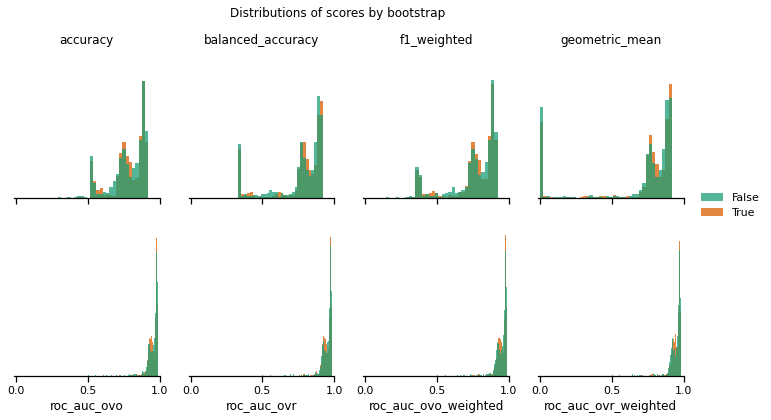

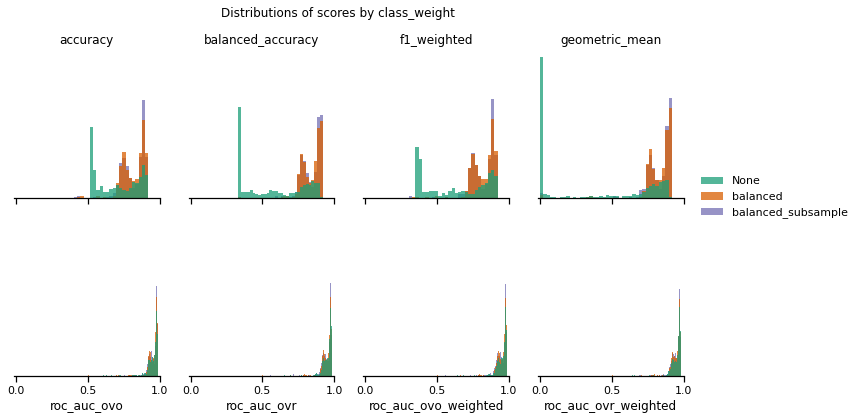

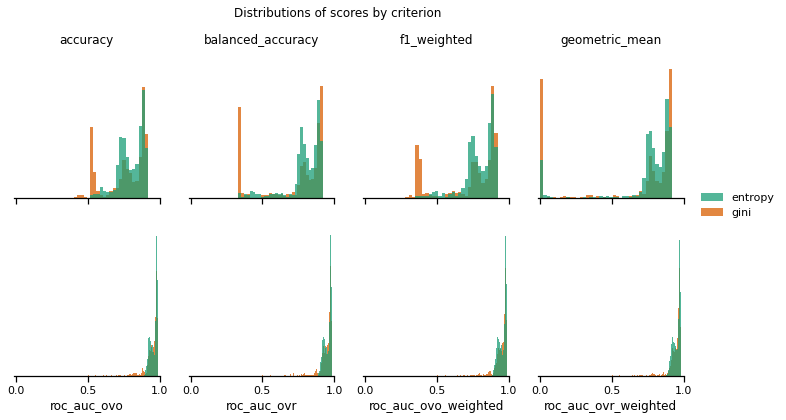

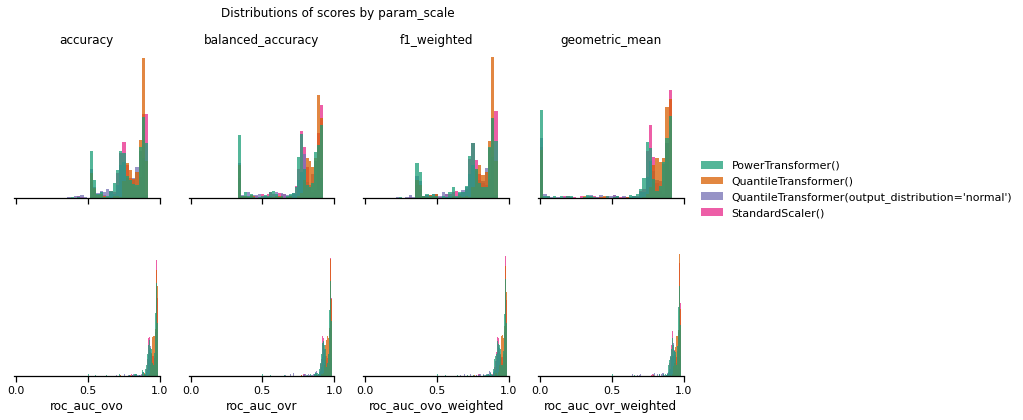

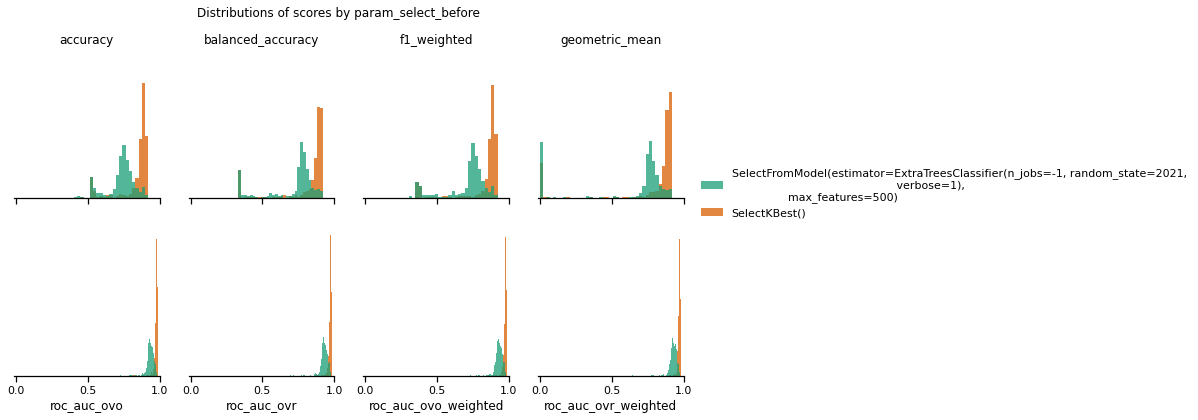

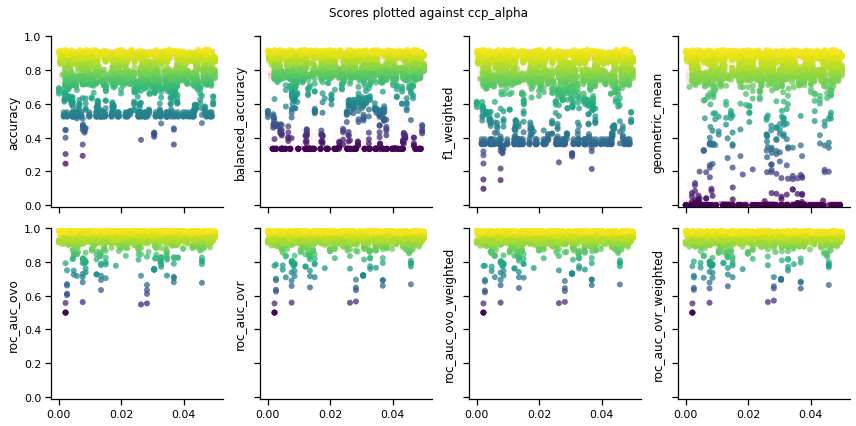

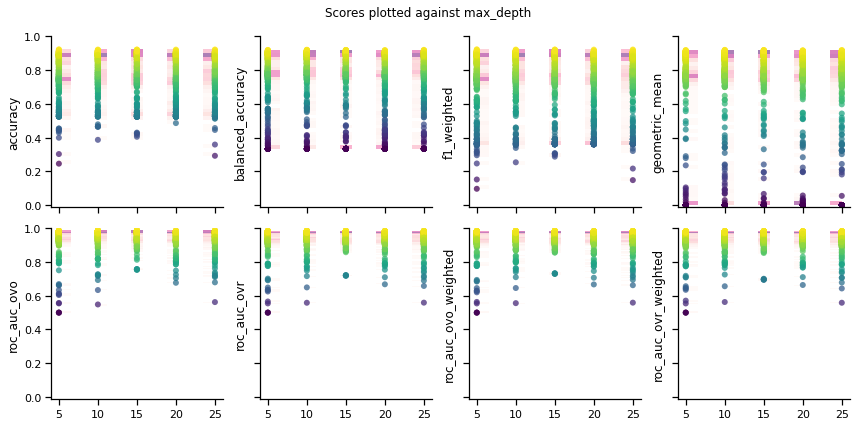

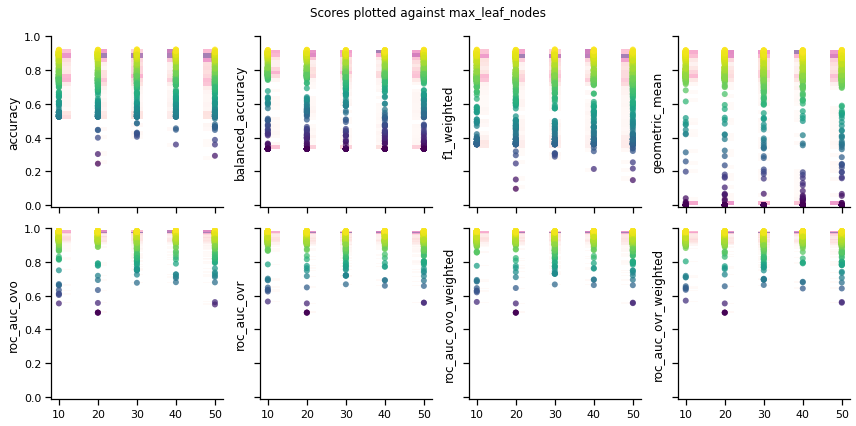

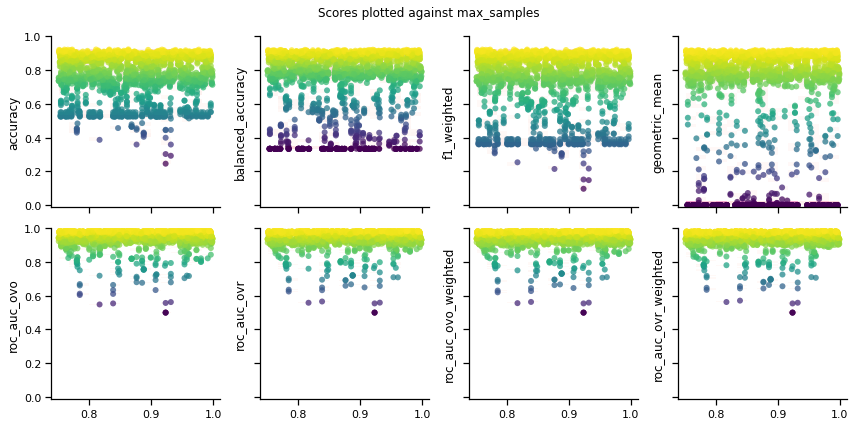

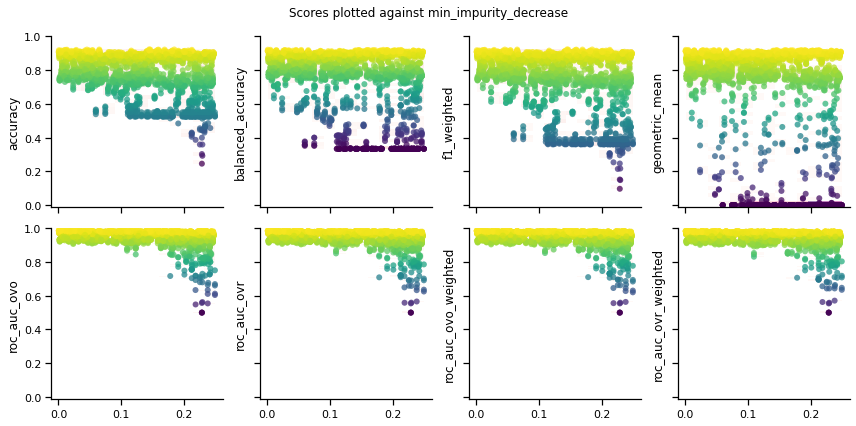

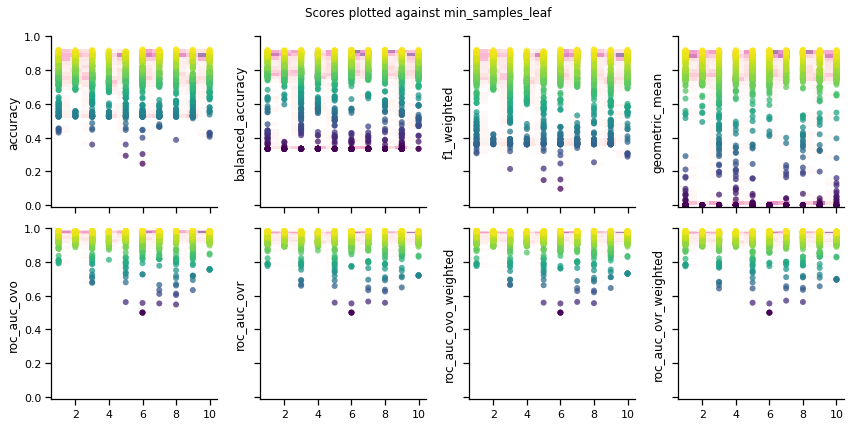

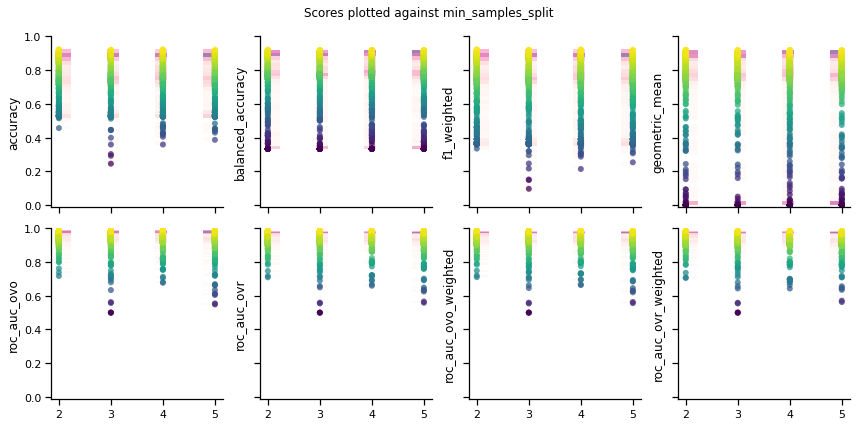

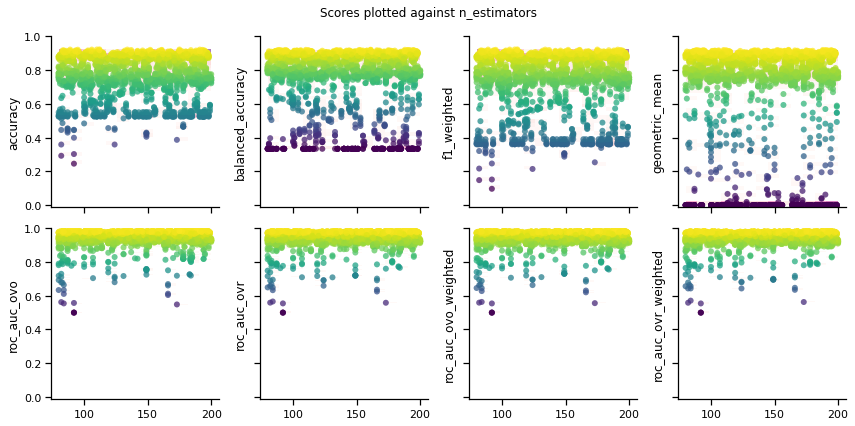

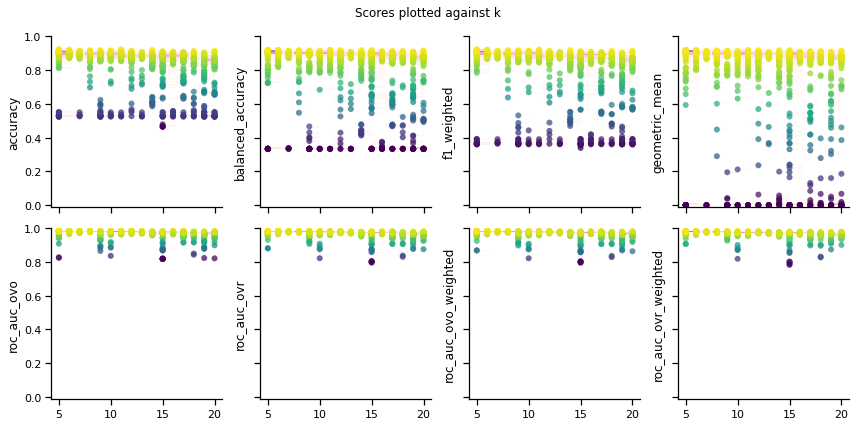

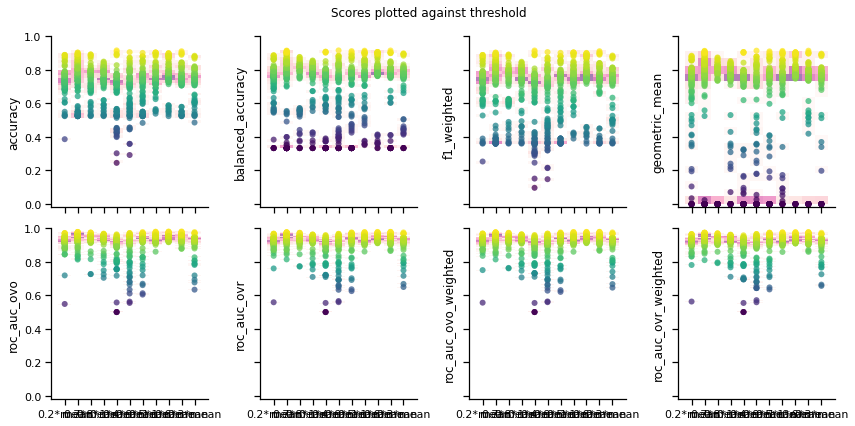

time: 29.3 s


In [16]:
df_ = pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/ExtraTrees_hypersearch.feather"
        )
        for fold_num in FOLDS
    ]
).reset_index(drop=True)
# plot categoricals
for catcol in catcols:
    df = (
        df_.loc[:, [catcol] + metriccols].fillna("None").dropna()
    )  # removes disjoint hyperparameter results
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(num_cols * 3, num_rows * 3),
    )
    hue_order = sorted(df[catcol].unique())
    _ = df[metriccols]
    xmin = _.min().min() - (1.0 - _.max().max())  # lowest score - (1 - highest score)
    # with xmax set at 1.0, this makes equal empty space on either side from the highest and lowest scores
    _ = gc_collect()
    metrics = list(METRICS.keys())
    for row in (0, 1):
        for col in (0, 1, 2, 3):
            ax = axes[row, col]
            _ = sns.histplot(
                data=df,
                x=f"mean_test_{(metric := metrics.pop(0))}",
                hue=catcol,
                palette="Dark2",
                hue_order=hue_order,
                ax=ax,
                linewidth=0,
                alpha=0.75,
            )
            if ax != axes[num_rows - 1, num_cols - 1]:
                _ = ax.get_legend().remove()
            if row:
                _ = ax.set_title("")
                _ = ax.set_xlabel(metric)
            else:
                _ = ax.set_title(metric)
                _ = ax.set_xlabel("")
            _ = ax.set_xlim(xmin=xmin, xmax=1.0)
            _ = ax.set_ylabel("")
            _ = ax.set_yticks([])
    sns.move_legend(
        axes[-1, -1],
        "lower left",
        bbox_to_anchor=(1.05, 1),
        title="",
        frameon=False,
    )
    sns.despine(top=True, right=True, left=True)
    _ = plt.suptitle(f"Distributions of scores by {catcol.split('__')[-1]}")
    plt.show()
    del df
    _ = gc_collect()
# plot numerics
for numcol in numcols:
    df = df_.loc[
        :, [numcol] + metriccols
    ].dropna()  # removes disjoint hyperparameter results
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        figsize=(num_cols * 3, num_rows * 3),
    )
    _ = df[metriccols]
    ymin = _.min().min() - (1.0 - _.max().max())  # lowest score - (1 - highest score)
    # with ymax set at 1.0, this makes equal empty space on either side from the highest and lowest scores
    _ = gc_collect()
    metrics = list(METRICS.keys())
    for row in (0, 1):
        for col in (0, 1, 2, 3):
            ax = axes[row, col]
            _ = sns.histplot(
                data=df,
                x=numcol,
                y=(y := f"mean_test_{(metric := metrics.pop(0))}"),
                cmap="RdPu",
                ax=ax,
                linewidth=0,
                alpha=0.5,
                legend=False,
                kde=True,
            )
            _ = sns.scatterplot(
                data=df,
                x=numcol,
                y=y,
                hue=y,
                palette="viridis",
                ax=ax,
                linewidth=0,
                alpha=0.75,
                legend=False,
            )
            _ = ax.set_xlabel("")
            if col:
                _ = ax.set_yticklabels([])
            _ = ax.set_ylim(ymin=ymin, ymax=1.0)
            _ = ax.set_ylabel(metric)
    sns.despine(top=True, right=True)
    _ = plt.suptitle(f"Scores plotted against {numcol.split('__')[-1]}")
    plt.tight_layout()
    plt.show()
    del df
    _ = gc_collect()
del df_
_ = gc_collect()

# Discussion

Although best performance may not be achieved through naively including all crafted features, structural multicollinearity doesn't seem to be too much of a problem.

Resampling is an expensive procedure to tune. We may have to focus on other parts of the pipeline first. After those configurations are settled, we can try maybe one or two resampling approaches and hope one of them boosts performance. Again, it will be difficult to find the best method; rather, we should aim to find a good method.

The inner CV hyperparameter search likely overfits because of speaker leakage. However, there is no speaker leakage in the outer folds. Although the cross-validated scores should be reliable, the hyperparameters found may not be optimal. This will be less of an issue when training the full prototype, however, as hyperparameter search will be cross-validated over the entire dataset rather than a single prepared (no speaker leakage) fold at a time (non-nested hyperparameter search).

For the ExtraTrees algorithm, optimizing for one score may be approximately equivalent to optimizing for the others too.

Scaling is a bottleneck. We can choose one or two methods and pre-compute them for next time. Unfortunately, I couldn't get caching of the transformers to work.

Some of these parameters don't seem to matter too much. Bootstrapping is probably good. Balanced_subsample is probably good. QTuni is probably good, maybe SS. SelectKBest is better than selectfrommodel probably. k can be fairly small. threshold around mean is good. more estimators the better probs. min impurity decrease less than 0.2 please. Some higher scores were achieved with smaller grids previously.

We could keep tuning or try another model. Next steps are to prepare a uniform quantile transform. Then we'll adapt the harness for GaussianNB.

In [17]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 90417.17494416237 s
time: 104 ms


[^top](#Contents)